## Imports and Setup

In [1]:
#@Imports
import sys
import os
path = os.path.abspath('../..')
if path not in sys.path:
  sys.path.insert(0, path)

%load_ext autoreload

import collections
import concurrent.futures
import datetime
import json
import termcolor
import re

import numpy as np

from IPython import display

from concordia.agents import basic_agent
from concordia.components import agent as components
from concordia import components as generic_components
from concordia.associative_memory import associative_memory
from concordia.associative_memory import blank_memories
from concordia.associative_memory import formative_memories
from concordia.associative_memory import importance_function
from concordia.clocks import game_clock
from concordia.components import game_master as gm_components
from concordia.environment import game_master
from concordia.metrics import goal_achievement
from concordia.metrics import common_sense_morality
from concordia.metrics import opinion_of_others
from concordia.typing import agent as simulacrum_agent
from concordia.utils import html as html_lib
from concordia.utils import measurements as measurements_lib
from concordia.utils import plotting

from examples.custom_components.setup import model_setup, measurement_setup

In [2]:
#@Model Setup
model, embedder = model_setup('llama3:70b', local_models=True)
measurements, clock = measurement_setup(
  SETUP_TIME=datetime.datetime(hour=21, year=2024, month=10, day=1), 
  time_step = datetime.timedelta(minutes=5))

#@title Importance models
importance_model = importance_function.ConstantImportanceModel()
importance_model_gm = importance_function.ConstantImportanceModel()

## Scenario Details

In [3]:
#@Shared Memories

# The generic context will be used for the NPC context. It reflects general
# knowledge and is possessed by all characters.
scenario_premise = [
  (
    'It is 9pm on a weeknight. ' +
    'Alice returns late from work and finds her friend Dorothy at her doorstep. '
  ),
]
shared_context = model.sample_text(
  'Summarize the following passage in a concise and insightful fashion:\n'
  + '\n'.join(scenario_premise)
  + '\n'
  + 'Summary:'
)

#@title Creating character backgrounds, goals and traits. Modify to explore how it influences the outcomes

player_configs = [
  
  # Dorothy
  formative_memories.AgentConfig(
    name='Dorothy',
    gender='female',
    goal=(
      'Dorothy has to move out of her house tonight and needs someone to help her move. ' +
      "Dorothy had planned on Bob helping her move, but Bob didn't show up. " 
    ),
    context=shared_context,
    traits='responsibility: medium; aggression: medium',
  ),

  # Alice
  formative_memories.AgentConfig(
    name='Alice',
    gender='female',
    goal='Alice is exhausted after work, and she needs to help her grandmother all day the next day.',
    context=shared_context,
    traits='responsibility: medium; aggression: medium',
  )
]

#@Memory factories
blank_memory_factory = blank_memories.MemoryFactory(
  model=model,
  embedder=embedder,
  importance=importance_model.importance,
  clock_now=clock.now,
)

formative_memory_factory = formative_memories.FormativeMemoryFactory(
  model=model,
  shared_memories=scenario_premise,
  blank_memory_factory_call=blank_memory_factory.make_blank_memory,
)

Alice arrives home from work late on a weekday evening to find an unexpected visitor, her friend Dorothy, waiting for her at the doorstep.

## Agent Structure

In [4]:
#@Define agent structure
%autoreload 2
from examples.custom_components import tpb_llama3 as tpb

def build_agent(player_config: formative_memories.AgentConfig) -> basic_agent.BasicAgent:

  mem = formative_memory_factory.make_memories(player_config)

  observation = components.observation.Observation(
    agent_name=player_config.name,
    clock_now=clock.now,
    memory=mem,
    component_name="observation",
    timeframe=clock.get_step_size()
  )

  behav = tpb.Behaviour(
    "behaviour",
    model=model,
    memory=mem,
    player_config=player_config,
    num_behavs=5
  )

  attitude = tpb.Attitude(
    "attitude",
    model=model,
    memory=mem,
    player_config=player_config,
    components=[behav],
  )

  people = tpb.People(
    "people",
    model=model,
    memory=mem,
    player_config=player_config,
    components=[behav]
  )

  motiv = tpb.Motivation(
    "motivation",
    model=model,
    memory=mem,
    player_config=player_config,
    components=[people]
  )

  norm = tpb.SubjectiveNorm(
    "norm",
    model=model,
    memory=mem,
    player_config=player_config,
    components=[motiv]
  )

  full_model = tpb.TPB(
    "tpb",
    model=model,
    memory=mem,
    player_config=player_config,
    components=[attitude,norm]
  )

  persona = generic_components.sequential.Sequential(
    name='persona',
    components=[
      behav,
      attitude,
      people,
      motiv,
      norm,
      full_model
    ]
  )

  situation = components.situation_perception.SituationPerception(
    name='situation',
    model=model,
    memory=mem,
    agent_name = player_config.name,
    clock_now=clock.now
  )

  plan = components.plan.SimPlan(
    model=model,
    memory=mem,
    agent_name=player_config.name,
    clock_now=clock.now,
    components=[situation],
    goal=full_model,
    time_adverb='5-minute',
    timescale='the next hour'
  )

  full_plan = generic_components.sequential.Sequential(
    name='full_plan',
    components=[
      observation,
      persona,
      plan
    ]
  )

  agent = basic_agent.BasicAgent(
    agent_name=player_config.name,
    model=model,
    memory=mem,
    clock=clock,
    components=[full_plan]
  )
  
  return agent

In [5]:
#@Build agents
NUM_PLAYERS = 2
agents = []
with concurrent.futures.ThreadPoolExecutor(max_workers=NUM_PLAYERS) as pool:
  for agent in pool.map(build_agent,
            player_configs[:NUM_PLAYERS]):
    agents.append(agent)

Dorothy grew up in a small town surrounded by rolling hills and vast fields of wheat. As a child, she was always fascinated by the way the sunlight danced across the landscape, and she spent hours exploring the outdoors with her siblings. Her parents, though loving, were busy running their family farm, so Dorothy learned early on to take responsibility for herself and help out whenever possible. This sense of duty stuck with her as she grew older, and she developed a strong work ethic that would serve her well in life.

As an adult, Dorothy became a skilled botanist, dedicating her days to studying the unique flora of the countryside. Her typical day was filled with long walks through the fields, collecting samples and making notes in her worn leather journal. She dreamed of one day discovering a new species, and her passion drove her to work tirelessly towards that goal. Despite her medium level of aggression, Dorothy was never afraid to speak her mind and stand up for what she believ

TypeError: Observation.__init__() missing 1 required positional argument: 'timeframe'

## GM Structure

In [ ]:
game_master_memory = associative_memory.AssociativeMemory(
   sentence_embedder=embedder,
   importance=importance_model_gm.importance,
   clock=clock.now)

agent_list = [agent.name for agent in agents]

scenario_knowledge = generic_components.constant.ConstantComponent(
    state=' '.join(shared_context),
    name='Background')

player_status = gm_components.player_status.PlayerStatus(
    clock_now=clock.now,
    model=model,
    memory=game_master_memory,
    player_names=agent_list)


convo_externality = gm_components.conversation.Conversation(
    players=agents,
    model=model,
    memory=game_master_memory,
    clock=clock,
    burner_memory_factory=blank_memory_factory,
    components=[player_status],
    cap_nonplayer_characters=3,
    shared_context=shared_context,
    verbose=False,
)

direct_effect_externality = gm_components.direct_effect.DirectEffect(
    players=agents,
    model=model,
    memory=game_master_memory,
    clock_now=clock.now,
    verbose=False,
    components=[player_status]
)

relevant_events = gm_components.relevant_events.RelevantEvents(
    clock.now, model, game_master_memory)
time_display = gm_components.time_display.TimeDisplay(clock)

In [ ]:
# @title Create the game master object
env = game_master.GameMaster(
    model=model,
    memory=game_master_memory,
    clock=clock,
    players=agents,
    components=[
        scenario_knowledge,
        player_status,
        convo_externality,
        direct_effect_externality,
        relevant_events,
        time_display,
    ],
    randomise_initiative=False,
    player_observes_event=False,
    players_act_simultaneously=False,
    verbose=True,
)

In [ ]:
# @title Expect about 2-3 minutes per step.
episode_length = 4  # @param {type: 'integer'}
for _ in range(episode_length):
  CALL_TO_ACTION = (
    "Given the above, what will {agent_name} do for the "
    "next {timedelta} to achieve their current plan?"
  )
  env.step(action_spec = simulacrum_agent.ActionSpec(call_to_action=CALL_TO_ACTION,output_type="FREE"))

TypeError: ActionSpec.__init__() missing 1 required positional argument: 'output_type'

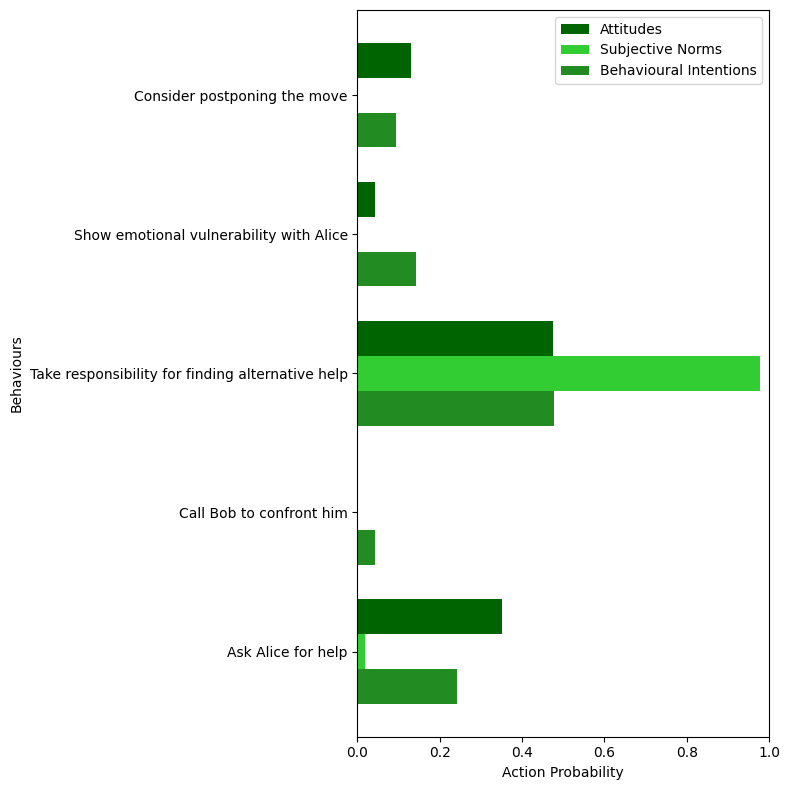

None


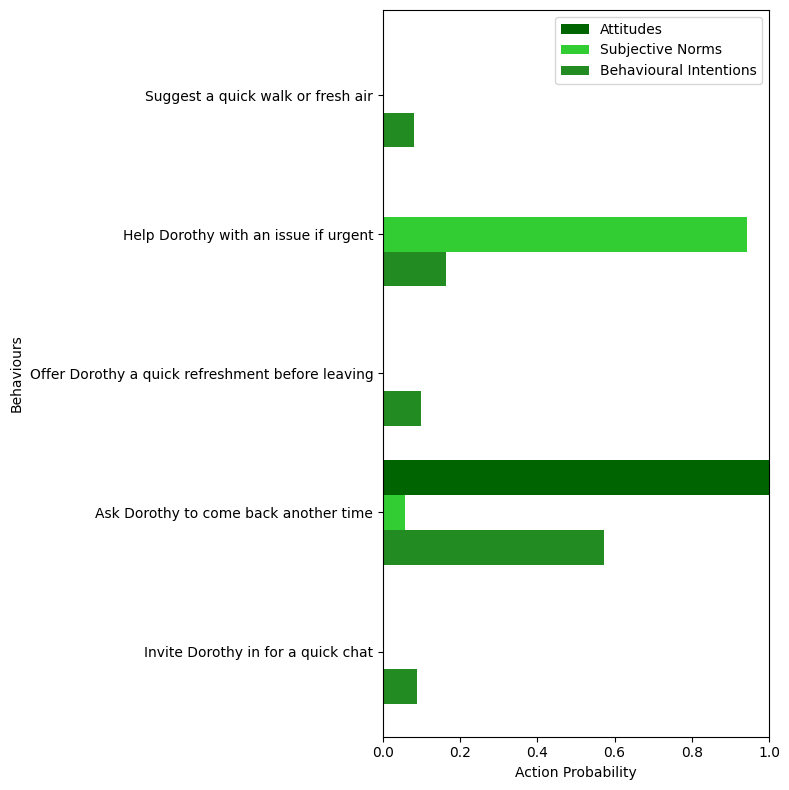

None


In [ ]:
for agent in agents:
  print(agent._components["full_plan"]._components[0]._components[5].plot())

### Things to add

- Summarize deliberation on the potential actions, including thoughts on the possible positive and negative consequences (counterfactuals should remain throughout the whole)
- 